# Abstract

This final project focused on <i>sentiment analysis</i>, more specifically, classifying a given text (tweet in this case) as carrying a "positive" emotion or a "negative" emotion. For the purpose of this classification, this project wrote and implemented the PEGASOS algorithm to solve the primal formulation of SVMs (Support Vector Machines). The primal formulation of SVM is a convex optimization problem that aims to find the optimal hyperplane that maximally separates the classes in a binary classification task. Furthermore, this  project dealt with the vectorization of text-based data, and the parameters which affect how text is stored in a way a machine learning model can understand. Through hyperparameter tuning, this project was able to arrive at a $72$% accuracy on the <i>testing data</i> in predicting the emotion of a text (positive or negative). The limitation of the model created in this project is that it follows a "bag-of-words" approach - therefore, this model does not understand the "contextual" meaning of words.

<a href="https://github.com/dcruzeneil/Mental-Health-Tweetment"><b>GitHub Repository: <i>Mental Health Tweetment</i></b></a>

# Introduction

Sentiment Analysis is an evergrowing field with applications in many areas like analyzing customer feedback, social media monitoring, and so on. However, the primary purpose for this project was to create a sentiment analyis model which can discern "positive" tweets from "negative" tweets. Although, the data set used was the twitter data set, this problem is not limited to that. Having a model which can discern "positive" emotions from "negative" emotions (represented through text) can be really helpful in diagnosing and help people who might be suffering from mental health issues. 

For the purpose of this project, the model was a binary classifier. This is because the data set which contained the tweets only had two annotations: (0) negative, and (4) positive. However, there have been other works where the range of annotations is higher - very (negative/positive), slightly (negative/positive), and neutral. This multi-class classification might lead to a more nuanced model which can better understand the emotion of a text [@MulticlassSVM]. Furthermore, there have also been research in which the SVM has been trained on data from multiple sources, and there has been use of uni-grams and bi-grams in the model. This project will aim to borrow some ideas from this paper, particularly, the use of unigram and bigrams in the term-document matrix [@unigram]. Lastly, there has also been research which inspired future work I could do in this project, including emoticons in the analysis of sentiment of tweets [@SentimentDistantSupervision].

# Values Statement
The main idea behind this project was to come up with a machine learning model which can potentially be used to intervene and assist people in need of mental health support. Although, one major drawback of this model is that it does not understand the contextual meaning of words. 

I am not particularly sure how this project would be implemented - given that implementing a model which analyzes "text" written by someone can be considered a breach of privacy. However, the potential users for this project could be mental health experts, who want to leverage the power of technology to get a better understanding of people (patients) who visit them. This model will benefit in the diagnosis of people who are suffering from mental health issues and allow intervention. Although this project does not directly harm anyone, the fact that it is trained over a data set which contained tweets in English means that anyone who does not know English is actively excluded from the benefits of this model.

I am really interested in learning about and applying technological solutions which can solve real-life social issues. Due to this, I was really interested in applying my knowledge of machine learning in creating something which could potentially benefit other people. Based on my reflection, if my model had a higher accuracy rate, and if it were implemented respecting an individual's privacy - my model would make the world a more <i>joyful</i> place!

# Materials and Methods
The data set chosen for this project is called the <a href="https://www.kaggle.com/datasets/kazanova/sentiment140?datasetId=2477">Sentiment140</a> data set, which contains $1.6$ million tweets, which are annotated as Negative (0) and Positive (4). Each row of this data set contains information for a tweet: Sentiment, Tweet ID, Time of Tweet, Username, Tweet, and so on. A potential limitation of this data set is that it only contains tweets which were written in English, therefore, this model excludes people who speak other languages. The chosen model to train this data on was SVM, although, the main question was between: the <i>Primal</i> form of SVM, and the <i>Dual</i> form of SVM. Since we are dealing with linearly separable data, with fewer features compared to samples - the choice was <i>Primal SVM</i>. The <i>Dual</i> form of SVM, would have proven to be very computationally expensive, especially because of the construction of the <i>kernel</i>!

#### <font color="green">Sampling the Data</font>
Before, we begin doing anything it is important to understand that the <i>Sentiment140</i> is a huge data set, which makes many computations very time-consuming. Therefore, we are going to sample the data set to select $50000$ data points (rows) randomly. The code which was used to sample the data is:
```python
import pandas as pd
df = pd.read_csv(r"datasetOriginal.csv", encoding="latin-1")
df = df.sample(n=50000)
df.to_csv("dataset.csv", index = False)
```

So, now we are working with a dataset which is way more manageable!

#### <font color = "green">Loading the Data and Feature Selection</font>
Before we perform any of our evaluations, we must prepare our data. For this, we will be using the <i>loadData</i> method from HelperClass:

```python
def loadData(self):
    columns = ['Sentiment Score', 'Tweet ID', 'Time', 'Query', 'Username', 'Tweet']
    df = pd.read_csv(r"dataset.csv", encoding="latin-1", names = columns)
    df = df[["Sentiment Score", "Tweet"]]
    return df
```
In the above operation, we are assigning adequate feature (column) names to the data. This dataset has a bunch of features, however, we are primarily interested in the: 
<ol>
    <li><i><u>Tweet</u></i> feature: which contains the actual tweet - (Predictor) which will be used for Sentiment Analysis
    <li><i><u>Sentiment Score</u></i> feature: which contains the true labels - (Target Vector) the actual assigned sentiment for each tweet 
</ol>

Now, we can go ahead and store our data as a <i>pandas</i> data frame:

In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
from HelperClass import HelperClass

hp = HelperClass()
df = hp.loadData()

To get an understanding of what the data looks like, we can go ahead and examine the first few rows of the data:

In [2]:
df.head()

,Sentiment Score,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,my last day
2,0,"my elbow really hurts, whacked it off @lydiaro..."
3,4,@MildManneredBoy Well thank you very much sir
4,4,@KylieLuvsJonas we need creeper rings! like yo...


Therefore, we can see that now our data solely consists of the Sentiment Score and the Tweet. To understand the distribution of this data, we can perform:

In [3]:
df.groupby("Sentiment Score").size()

Sentiment Score
0    24940
4    25061
dtype: int64

So, we can clearly see that there are $24940$ tweets which are: Negative ($0$), and there are $25061$ tweets which are: Positive ($4$)!

#### <font color = "green"> Preprocessing Tasks </font>
To increase accuracy, and to make our input data better, we perform certain "preprocessing" tasks on the raw text data. Peforming the following tasks on the data:
<ol>
    <li> Casing: converting everything to either uppercase or lowercase
    <li> Noise Removal: eliminating unwanted characters such as HTML tags, punctuation marks, special characters, and so on
    <li> Tokenization: turning all the tweets into tokens - words separated by spaces
    <li> Stopword Removal: ignore common English words ("and", "if", "for"), that are not likely to shape the sentiment of the tweet
    <li> Text Normalization (Lemmatization): reducing words to their root form to eliminate variations of the same word
        <ul>
            <li> Better $\rightarrow$ Good
            <li> Runs/Running/Ran $\rightarrow$ Run
        </ul>
</ol>

In [4]:
for i in range(df.shape[0]):
    df["Tweet"][i] = hp.preprocess(df["Tweet"][i])

#### <font color="green">Training Data, Validation Data and Testing Data</font>

Before, we proceed with any operation it is important to divide our data into <i>training data</i>, <i>validation data</i> and <i>testing data</i>:

In [5]:
from sklearn.model_selection import train_test_split 
dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(df["Tweet"], df["Sentiment Score"], test_size=0.2, random_state=0)

The code above splits our entire data: the actual tweets, and the associated sentiment score - into training data and testing data. This data exists in the form of <i>pandas</i> dataframes. The <i>test_size</i> = 0.2, tells the function to save 20% of the data (roughly $10,000$ data points) for testing, and the rest ($40,000$) for training.

In [6]:
dfX_test, dfX_val, dfY_test, dfY_val = train_test_split(dfX_test, dfY_test, test_size=0.5, random_state=0)

The code above splits the testing data into 50%, so that the <i>validation data</i> also has around 5000 data points. 

<b><u>Note</u>: 50,000 Total Data = 40,000 Training (80%) + 5000 Validation (10%) + 5000 Testing (10%)</b> - which is a pretty good split!</b>

#### <font color="green">Creating the Term-Document Matrix and the Target Vector</font>
Now that we have our training and testing data frames, we want to separate it into the:
<ul>
    <li> Feature Matrix (X), and
    <li> Target Vector (y)
</ul>
Luckily, for us the sentiment score is already numerically encoded (0 = Negative, and 4 = Positive). Although, we will convert this to -1 and 1 (for, 0 and 4 respectively) to standardize how SVM model predictions work. However, we must note that each individual tweet is like an individual row of the Feature Matrix - X. However, currently it is not represented in that format. To achieve that we have to create a "Term-Document Matrix". A term-document matrix is a matrix in which:
<ol>
    <li>Column: each column represents one term (word) that is present in our complete dataset (corpus) of the tweets
    <li>Row: each row contains information about one tweet (document), that is which words are present in that particular tweet
</ol>
To think of it simply, all the columns collectively represent all the words that have come up in the complete tweet dataset. Each row, contains tells us, out of all the possible words, which ones are present (and with what frequency) in each individual tweet. Therefore, our term-document matrix will be of the order: $\text{tdm} \in \mathbb{R}^{n\text{x}p}$, where $n$ = number of tweets, and $p$ = unique words across all tweets. 

<br><u>Important Note</u>: in the above description of the columns, all the words in the "complete tweet dataset" refers solely to the training data. This is because when we create the list of vocabulary (all the relevant words present in the tweets), we do not want to look at words in the <i>testing data</i> as that might lead to unwanted biases!

To create our term-document matrix, we can use the <i>CountVectorizer</i> from <i>scikit-learn</i>:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(min_df = 0.001, ngram_range=(1,2))

In the above code, we create an instance of the <i>CountVectorizer</i> class. Here there are some important things to unpack:
<ol>
    <li>min_df: if a term appears in less than 1% of the dataset - ignore it. As we do not have enough data on this term to understand its role in shaping a tweet's sentiment
    <li>ngram_range = (1,2): this tells our model to look at uni-grams (one word at a time), and bi-grams (two words taken together). This is good to understand words that often make sense in pairs
</ol>

Now, we can go ahead and create our term-document matrix (<i>tdm</i>) and appropriate <i>target vector</i> for the training, validation and testing data:

In [8]:
X_train, y_train = hp.prepData(dfX_train, dfY_train, cv, True)
X_test, y_test = hp.prepData(dfX_test, dfY_test, cv, False)
X_val, y_val = hp.prepData(dfX_val, dfY_val, cv, False)

The <i>prep_data</i> function, we use for getting the final <i>feature matrix</i> and <i>target vector</i> is defined as:
```python
def prepData(self, dfX, dfY, vectorizer, train = True):
    if train:
        vectorizer.fit(dfX)
    #creating the term document matrix
    counts = vectorizer.transform(dfX) 
    X = pd.DataFrame(counts.toarray(), columns = vectorizer.get_feature_names_out())
    X = X.to_numpy()
    y = dfY.to_numpy()
    y = np.where(y == 0, -1, np.where(y == 4, 1, y)) 
    return X, y
```
There are some things to unpack here:
<ol>
    <li>The check for training ensures that vocabulary is only created for the training data
    <li>Based on this constructed vocabulary, a term-document matrix is constructed (for both training and testing data)
    <li>We convert our <i>feature matrix</i> and <i>target vector</i> to numpy objects for ease
    <li>We change: $y = \{0, 4\}^{n}$ to $y = \{-1, 1\}^{n}$ for the SVM approach
</ol>

# PEGASOS (<font color="green">P</font>rimal <font color="green">E</font>stimated sub-<font color="green">G</font>r<font color="green">A</font>dient <font color="green">SO</font>lver for <font color="green">S</font>VM) : <font color = "green">Primal SVM</font>

In PEGASOS (Primal Form of SVM), our empirical risk minimization problem is:<br><br>
<center> $\hat{\mathbf{w}} = \mathop{\mathrm{arg\,min}}_{\mathbf{w}} \; L(\mathbf{w})\;$ </center>
<br>where, our loss function $L(\mathbf{w})\;$is defined as:<br><br>
<center> $L(\mathbf{w}) = \frac{\lambda}{2}||w||^2 + \frac{1}{n} \sum_{i = 1}^n \ell_{\text{hinge}}(\langle \mathbf{w}, \mathbf{x}_i \rangle, y_i)\;$ </center>

```python
def loss(self, X, y):
    y_hat = X@self.w
    hinge_loss = np.mean(self.hinge_loss(y_hat, y))
    l2_norm = (self.lamb/2) * np.sum(self.w ** 2)
    return l2_norm + hinge_loss
```

<br>Therefore, we can see that there is an added regularization to prevent overfitting and to increase the model's ability to generalize over unseen data. For PEGASOS, the loss function which is generally used is called "Hinge Loss", which is defined as:<br><br>
$$
\ell_{\text{hinge}}(\langle \mathbf{w}, \mathbf{x}_i \rangle, y_i) = \text{max}\{0, 1 - y_i\langle w, x_i \rangle\}
$$
```python
def hinge_loss(self, y_hat, y):
    return np.maximum(0, 1 - (y * y_hat))
```

In this case, our sub-gradient function is:<br><br>
$$
\nabla L(\mathbf{w}) = \lambda w - \frac{1}{n} \sum_{i = 1}^n \mathbb{1}[y_i \langle \mathbf{w}, \mathbf{x}_i \rangle < 1] y_i x_i
$$
```python
def gradient_hinge_loss(self, X, y):
    y_hat = X@self.w 
    tempVal = 1 * ((y_hat * y) < 1)

    output = np.zeros((X.shape[1],))
    for i in range(X.shape[0]):
        output += tempVal[i] * np.dot(y[i], X[i])
    output = output/X.shape[0]

    output = np.dot(self.lamb, self.w) - output
    return output
```

The following paper provided inspiration for the math behind the PEGASOS model [@MathFormula].

# Results
#### <font color="green">Hyperparameter Tuning using Validation Data</font>

Before we train the model, we are going to use the validation data to find the ideal hyperparameters ($\lambda$ - lambda, and <i>batch size</i>) for our model. First let us see, what values of $\lambda$, yield good result. The $\lambda$ values would be tested in powers of $10$, while the rest of the hyperparameters remain fixed:

In [9]:
from PrimalSVM import PrimalSVM

powers = 10.0 ** np.array([-4, -3, -2, -1, 0, 1])

df = pd.DataFrame({"Lambda": [], "Training Score" : [], "Validation Score" : []})

for power in powers:    
    PS = PrimalSVM(power)
    PS.fit(X_train, y_train, 0.1, 10000, 500)
    to_add = pd.DataFrame({"Lambda" : [power], "Training Score" : [PS.score(X_train, y_train)], "Validation Score" : [PS.score(X_val, y_val)]})
    df = pd.concat((df, to_add))

df = df.set_index('Lambda')
print(df)

         Training Score  Validation Score
Lambda                                   
0.0001         0.752325          0.729654
0.0010         0.745025          0.730054
0.0100         0.717575          0.712458
0.1000         0.684825          0.679864
1.0000         0.674825          0.666867
10.0000        0.634100          0.634473


<u>Result 1</u>: Therefore, it seems that $\lambda = 0.001$ yields the best results on the <i>validation data</i>, so we can expect that this will also yield the best results on the <i>testing data</i>!

Next, we can see what values of <i>batch size</i> yield good results. We would test for a bunch of different values of <i>batch size</i>, while the other hyperparameters remain fixed:

In [10]:
batch_size = np.array([25, 50, 100, 250, 500, 650])

df = pd.DataFrame({"Batch Size": [], "Training Score" : [], "Validation Score" : []})

for batch in batch_size:
    PS = PrimalSVM(0.001)
    PS.fit(X_train, y_train, 0.1, 1000, batch)
    to_add = pd.DataFrame({"Batch Size" : [batch], "Training Score" : [PS.score(X_train, y_train)], "Validation Score" : [PS.score(X_val, y_val)]})
    df = pd.concat((df, to_add))

df = df.set_index('Batch Size')    
print(df)

            Training Score  Validation Score
Batch Size                                  
25.0              0.745375          0.728854
50.0              0.745400          0.727455
100.0             0.745350          0.729654
250.0             0.745175          0.728654
500.0             0.745475          0.731054
650.0             0.745025          0.731254


<u>Result 2</u>: Although the results are pretty close, it seems that the score stabilizes around <i>batch size</i> = $500$. So we can expect that this will also yield the best results on the <i>testing data</i>!

#### <font color="green">Training the Model</font>

Now, that we have an understanding of how the PEGASOS (Primal SVM) method works, and we have the ideal choice for the hyperparameters: 
<ol>
    <li> $\lambda = 0.001$ 
    <li><i>batch size</i> = $500$
</ol>

We can fit our model on the training data with the combination of these ideal parameters, and finally test on our <i>testing data</i>, to see what the final results are!

In [11]:
from PrimalSVM import PrimalSVM

PS_final = PrimalSVM(0.001)
PS_final.fit(X_train, y_train, 0.1, 10000, 500)

In [12]:
df = pd.DataFrame({"Data": [], "Score" : []})

to_add = pd.DataFrame({"Data" : ["Training Data"], "Score" : [np.round(PS_final.score(X_train, y_train), 2)]})
df = pd.concat((df, to_add))

to_add = pd.DataFrame({"Data" : ["Validation Data"], "Score" : [np.round(PS_final.score(X_val, y_val), 2)]})
df = pd.concat((df, to_add))

to_add = pd.DataFrame({"Data" : ["Testing Data"], "Score" : [np.round(PS_final.score(X_test, y_test), 2)]})
df = pd.concat((df, to_add))

df = df.set_index('Data')  
print(df)

                 Score
Data                  
Training Data     0.74
Validation Data   0.73
Testing Data      0.72


#### <font color="green">Final Training Accuracy</font>
Our model gets a $72$% score on the unseen <i>Testing Data</i>! Furthermore, our model gets a score of $73$% on the <i>Validation Data</i> and a score of $74$% on the <i>Training Data</i>

#### <font color="green">Limitations: Model Accuracy for Ambiguous Sentences</font>
First, let us look at how the trained model does in predicting the sentiments of some sentences which could potentially cause an issue:

In [13]:
testSentences = ["I love apples", "I hate oranges", "Today has been a bad day", "Yesterday was a pretty good day", "I am smiling", "I am happy", "I am not happy", "I am sad", "Coffee is amazing bad bad"]

df = pd.DataFrame({"Sentence": [], "Sentiment" : []})

for sent in testSentences:
    tempMatrix = hp.sentencePredict(sent, cv)
    result = PS_final.predict(tempMatrix)
    sentiment = "Negative"
    if(result==1):
        sentiment = "Positive"
    to_add = pd.DataFrame({"Sentence" : [sent], "Sentiment" : [sentiment]})
    df = pd.concat((df, to_add))

df = df.set_index('Sentence')
df

,Sentiment
Sentence,
I love apples,Positive
I hate oranges,Negative
Today has been a bad day,Negative
Yesterday was a pretty good day,Positive
I am smiling,Positive
I am happy,Positive
I am not happy,Positive
I am sad,Negative
Coffee is amazing bad bad,Negative


Therefore, our model seems to be doing pretty well for the first $6$ sentences, but as soon as we introduce "not" our model fails! In the sentence "I am not happy", our model does not contextually understand that "not" negates the sentence - therefore, probably using the weight of the word "happy" to classify the sentence as positive. Furthermore, in the sentence "Coffee is amazing bad bad", we can see the bag-of-words approach in play, introducing a couple of "bad"s at the end of the sentence, brings down the score of the sentence, making the model classify it as <i>Negative</i>!

#### <font color="green">Visualizing the Evolution of Training Loss</font>

In this section of the project, we can go ahead and visualize how the loss of our PEGASOS model evolves over iterations:

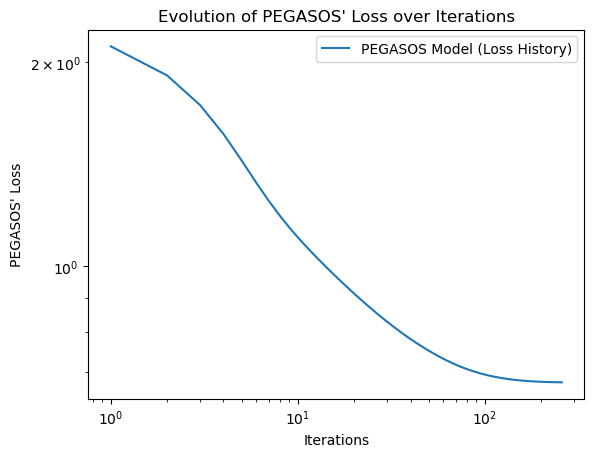

In [14]:
num_steps = len(PS_final.loss_history)
plt.plot(np.arange(num_steps) + 1, PS_final.loss_history, label = "PEGASOS Model (Loss History)")

plt.loglog()
plt.title("Evolution of PEGASOS' Loss over Iterations")
plt.xlabel("Iterations")
plt.ylabel("PEGASOS' Loss")

legend = plt.legend() 

#### <font color = "green">Comparison to Other Models</font>
In this section, we will implement some other models (pre-written in scikit learn) and see how they fare compared to this project's implementation of PEGASOS:

In [16]:
df = pd.DataFrame({"Model": [], "Training Score" : [], "Testing Score" : []})

to_add = pd.DataFrame({"Model" : ["PEGASOS"], "Training Score" : [0.74], "Testing Score" : [0.72]})
df = pd.concat((df, to_add))

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
to_add = pd.DataFrame({"Model" : ["Decision Tree"], "Training Score" : [DT.score(X_train, y_train)], "Testing Score" : [DT.score(X_test, y_test)]})
df = pd.concat((df, to_add))

# Logistic Regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train, y_train)
to_add = pd.DataFrame({"Model" : ["Logistic Regression"], "Training Score" : [LR.score(X_train, y_train)], "Testing Score" : [LR.score(X_test, y_test)]})
df = pd.concat((df, to_add))

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier()
SGD.fit(X_train, y_train)
to_add = pd.DataFrame({"Model" : ["Stochastic Gradient Descent"], "Training Score" : [SGD.score(X_train, y_train)], "Testing Score" : [SGD.score(X_test, y_test)]})
df = pd.concat((df, to_add))

# sorting based on performance on testing data
df = df.sort_values(by=['Testing Score'], ascending = False)

df = df.set_index("Model")
print(df)

                             Training Score  Testing Score
Model                                                     
Logistic Regression                0.753750         0.7362
Stochastic Gradient Descent        0.750625         0.7270
PEGASOS                            0.740000         0.7200
Decision Tree                      0.961400         0.6596


Therefore, we can see that in terms of performance on the unseen <i>testing data</i>, this project's implementation of PEGASOS is on $3\text{rd}$ position. However, one must note that the difference in the testing score between our model and the other scikit-learn model's is not that much, and the PEGASOS model fares pretty well with the other models!

# Concluding Discussion

Overall, I feel that my project met the goals that I had initially set! Although, I was not able to upload my model on a web-app which could be used by the public - that was an extended goal for this project. In terms of its primary goals, I was able to:
<ol>
    <li> Identify the Right Model for Training - <b>PEGASOS</b>
    <li> Prepare the Data for the Model 
    <li> Code and Implement the Model and Train 
    <li> Obtain a relatively good score on the <i>Testing Data</i>
</ol>

However, the model's score was not as high as I expected (wanted) it to be! Going into this project, I was aware that PEGASOS' sentiment analysis does not understand the words contextually - however, I wanted to implement the algorithm on my own, for which PEGASOS was a good choice. 

If I had more time, I would:
<ul>
    <li> Implement the use of emoticons while making decisions about the sentiment of the tweets [@SentimentDistantSupervision]
    <li> Use <i>transformers</i> to train a model which understands words contextually, and is able to discern sarcasm from true intent
</ul>

If I had more computation power, I would:
<ul>
    <li> Train my model over larger subset of the dataset, to see if that affects our <i>testing score</i>
</ul>

# Personal Reflection
Personally, I found the process of working on this project very enriching. This class has always been very hands-on, and working on this project was an extension of that. Through this project, I got acquainted with the workflow which is followed in a machine learning project. This was a good exercise to both get the data ready for the machine learning model (identifying and understanding the data set, and then vectorizing it), and to be able to read literature and scholarly papers and translate the math into code. Furthermore, this project made me appreciate the value of writing optimized code and choosing the right models - which do not cause heavy computational pressure on the device. I felt this when I was trying to work with the <i>Dual</i> form of SVM - which required the creation of a really large <i>kernel matrix</i>.

All in all, this project definitely has room for improvement, especially with the existence of models which can understand words contextually and discern sarcam from true emotions. However, I am satisfied with my findings in this project, and I feel that I met my goals just right (did not exceed them, and did not fall too short). One goal which I could not meet was uploading this model on a web-app, however, that was an extended goal and I aim to do that soon in the future.

This project definitely improved my ability to research machine learning topics, and to teach myself things. Therefore, this experience will definitely help me in my future courses and career. This is because tech is constantly evolving, and to learn new things, you have to be able to teach yourself.
